#**Neural Epidemiological Model and GUI**
---

**Scrum Master: Armaan Daryanani (AU 2026)**


**Product Owner: Taylor Bagwell (AU 2027)**


**Developer #1: Charlie Kemner (AU 2027)**


**Developer #2: Ian Mcgrady (AU 2027)**


**Developer #3: Raymond Dong (AU 2027)**

Our neural epidemoiological model is a Python software that uses neural networks through TensorFlow to predict the spread of viruses around the world.

Our project has two halves, the frontend GUI and the backend neural processing. Each of these two halves will be explained below.


>***For proper functionality, please download notebook file and all requisite files [here](https://github.com/ArmaanDaryanani/Neural-Epidemiological-Modeling-and-GUI) and run in a local IDE.***

##**GUI.py: Our Process**
---

> "**Dash** is an open-source framework for building data visualization interfaces. Released in 2017 as a Python library, it’s grown to include implementations for R, Julia, and F#. Dash helps data scientists build analytical web applications without requiring advanced web development knowledge" [source.](https://realpython.com/python-dash/#:~:text=Dash%20is%20an%20open%2Dsource,requiring%20advanced%20web%20development%20knowledge.)

Dash allows anyone to create simple to use interactive GUIs for web pages or for demonstrative purposes. For Group 10, Dash served as the cornerstone library in which we integrated both halves of our project. If you would like to learn more about how to use the Dash library,
[here is a good guide.](https://www.youtube.com/watch?v=hSPmj7mK6ng)

Lets download all requisite libraries for the GUI.py project:

In [ ]:
%pip install jupyter-dash
%pip install plotly
%pip install pycountry
%pip install geopandas

In the start, we have our imports and sample data (set to a lat long grid).

In [ ]:
"""
* GUI File
* Last Updated 10/17/23 by Armaan Daryanani
"""
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

In [ ]:
#sample data
data = {
    '2022-01-01': [(0, 51), (77, 29)],
    '2022-02-01': [(0, 51), (77, 29), (-99, 40)]
}

Initialize the dash app and slider for the date. dcc.graph() and dcc.slider() initializes the world map and slider functions built into Dash.

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='world-map'),
    dcc.Slider(
        id='date-slider',
        min=0,
        max=len(data.keys()) - 1,
        value=0,
        marks={i: date for i, date in enumerate(data.keys())},
        step=None
    )
])

Lastly, the update_map function will serve to update the map (from local data) based on the callback from the date-slider (world-map and date-slider from the graph and slider elements shown above). In update_map, it takes the data dictionary from the first block, iterates through it, and appends the (lon,lat) tuple to the traces array to be returned.

In [ ]:
@app.callback(
    Output('world-map', 'figure'),
    [Input('date-slider', 'value')]
)
def update_map(date_index):
    date = list(data.keys())[date_index]
    coords = data[date]

    traces = []
    for lon, lat in coords:
        traces.append(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            marker={'color': 'red', 'size': 10}
        ))

    layout = go.Layout(
        geo={'projection': {'type': "natural earth"}}
    )

    return {'data': traces, 'layout': layout}


if __name__ == '__main__':
    app.run()

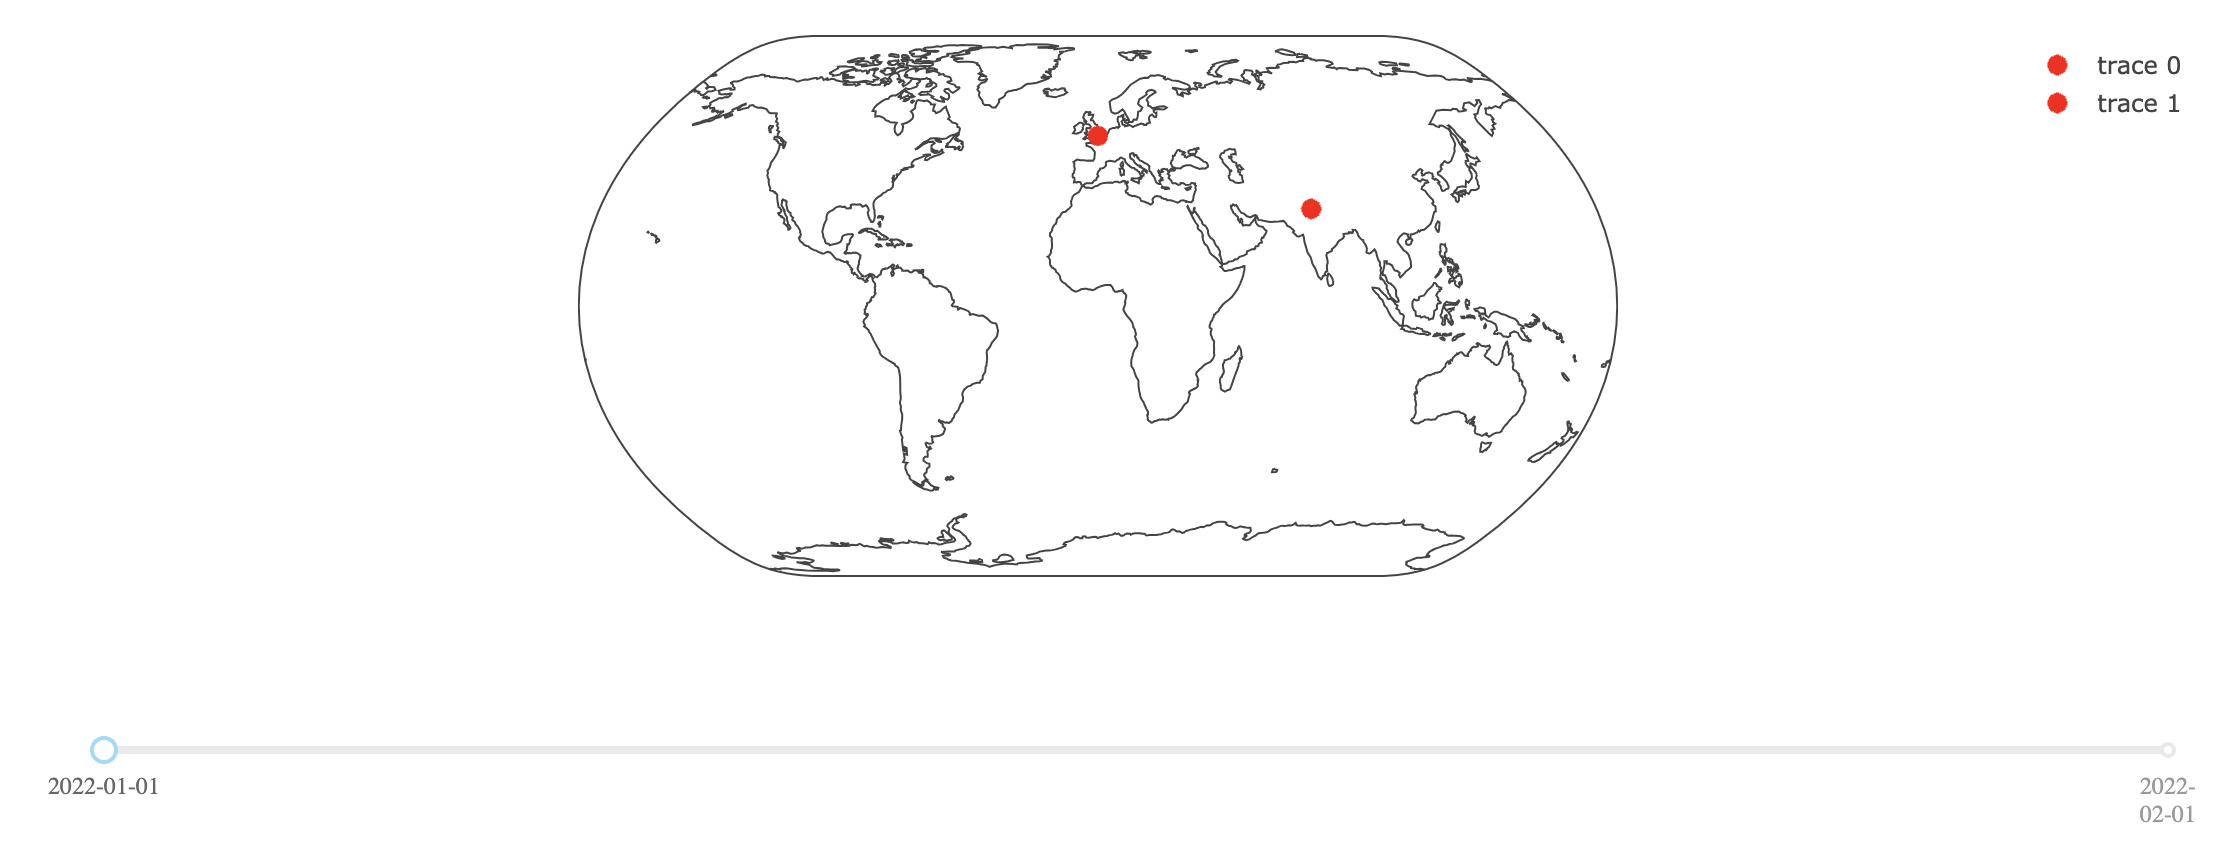

Let's fast forward 9 days and discusss the changes.

Imports are roughly the same, but we now have a CaseProcessing file which processes the large [text file of deaths](https://github.com/owid/covid-19-data/blob/master/public/data/cases_deaths/total_deaths.csv) from COVID into a managable format.

In [ ]:
"""
* GUI File
* Last Updated 10/26/23 by Armaan Daryanani
"""
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
from datetime import timedelta, datetime

from CaseProcessing import CaseProcessing

import pycountry

Serves to gather to the lat and long coordinates from each country.

In [ ]:
#reads filename data and stores as dict
def read_data_from_file(filename):
    country_data = {}
    with open(filename, 'r') as file:
        for line in file:
            split_line = line.strip().split("\t")
            country_code, lon, lat, country_name = split_line
            country_data[country_name] = (lat, lon)
    return country_data

filename = "countries.txt"
country_data = read_data_from_file(filename)

A lot of the functions are the same, except the added construct_data which adds points on the map if that current date has any new deaths (from the large text file). See documentation within the code for a more detailed explaination.

In [ ]:
#function to get latlong
def latlong(country_name):
    return country_data.get(country_name, (0, 0))  #default

def construct_data(deaths_filename):
    start_date_str = "2020-01-03"
    end_date_str = "2020-05-09"

    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    processor = CaseProcessing(deaths_filename)

    current_date = start_date
    data_dict = {}

    prev_latlong_values = set()  #store the previous date's values

    while current_date <= end_date:
        year, month, day = current_date.year, current_date.month, current_date.day
        country_deaths = processor.exclude_indexes(processor.get_country_deaths_dict(day, month, year))

        #get country names with deaths > 0
        countries_with_deaths = [country for country, deaths in country_deaths.items() if deaths > 0]

        #get the latlong values for these countries
        latlong_values = set([latlong(country) for country in countries_with_deaths])

        #remove (0, 0) from the list if it's present
        latlong_values.discard((0, 0))

        date_str = current_date.strftime('%Y-%m-%d')

        #find new points that weren't in the previous day's data
        new_points = latlong_values - prev_latlong_values

        #update the data dictionary for the day
        if new_points:
            #combine new points with previous points, placing new points at the top
            combined_points = list(prev_latlong_values) + list(new_points)
            data_dict[date_str] = combined_points

        prev_latlong_values = latlong_values

        #move to the next date
        current_date += timedelta(days=1)
    print(data_dict)
    return data_dict


#data points dict
data = construct_data("total_deaths.txt")

print(construct_data("total_deaths.txt"))

all_countries = [country.name for country in pycountry.countries]

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='world-map',
        config={
            'staticPlot': True  #disables interactivity
        },
        style={'height': '90vh', 'width': '95vw', 'margin': 'auto'}
    ),
    html.Div([
        dcc.Slider(
            id='date-slider',
            min=0,
            max=len(data.keys()) - 1,
            value=0,
            step=1  #changed from None to 1
        ),
        html.Button('Play', id='play-button'),
        dcc.Interval(
            id='interval-component',
            interval=1 * 1000,  #in milliseconds; 1*1000 means every second
            n_intervals=0,  #number of times the interval was activated
            max_intervals=-1,  # -1 means no limit
            disabled=True  #starts as disabled
        )
    ], style={'position': 'fixed', 'bottom': '2%', 'left': '2.5%', 'right': '2.5%'})
], style={'backgroundColor': 'white'})  #background color of the entire webpage


@app.callback(
    Output('world-map', 'figure'),
    [Input('date-slider', 'value')]
)
def update_map(date_index):
    date = list(data.keys())[date_index]
    coords = data[date]
    traces = []

    if date_index > 0:  #ensures there is a previous date to compare with
        prev_date = list(data.keys())[date_index - 1]
        prev_coords = data[prev_date]

        #if the current date_index is beyond the first index calculate the new points from two days ago.
        if date_index > 1:
            two_days_ago_date = list(data.keys())[date_index - 2]
            two_days_ago_coords = data[two_days_ago_date]
            new_points_prev_day = set(prev_coords) - set(two_days_ago_coords)
        else:
            #if it's the first index then all points from the previous day are considered new.
            new_points_prev_day = set(prev_coords)

        #calculate new points for the current date
        new_points = set(coords) - set(prev_coords)

        #draw lines between the new points of the current date and the new points from the previous day
        for lon, lat in new_points:
            for prev_lon, prev_lat in new_points_prev_day:
                traces.append(go.Scattergeo(
                    lon=[prev_lon, lon],
                    lat=[prev_lat, lat],
                    mode='lines',
                    line={'color': 'blue', 'width': 1},
                ))

    #draw the current points
    for lon, lat in coords:
        traces.append(go.Scattergeo(
            lon=[lon],
            lat=[lat],
            marker={'color': 'red', 'size': 10},
            mode='markers'
        ))

    #layout of the map we are using
    layout = go.Layout(
        geo={
            'projection': {'type': "mercator", 'scale': 1},
            'showland': True,
            'landcolor': 'green',
            'showcountries': True,
            'countrycolor': 'black',
            'countrywidth': 0.5,
            'center': {'lat': 30, 'lon': 0},
            'showframe': False,
            'showcoastlines': True,
            'lataxis': {'range': [-60, 80]},
            'lonaxis': {'range': [-180, 180]},
            'bgcolor': 'lightblue'
        },
        margin={"t": 0, "b": 0, "l": 0, "r": 0},
        showlegend = False
    )
    return {'data': traces, 'layout': layout}
@app.callback(
    Output('date-slider', 'value'),
    [Input('interval-component', 'n_intervals')],
    [State('date-slider', 'value')]
)
def update_slider(n, current_value):
    if current_value < len(data.keys()) - 1:
        return current_value + 1
    else:
        return current_value

@app.callback(
    [Output('interval-component', 'disabled'),
     Output('play-button', 'children')],
    [Input('play-button', 'n_clicks')],
    [State('interval-component', 'disabled')]
)
def toggle_play(n_clicks, currently_disabled):
    if n_clicks is None:  #the button was never clicked
        return True, "Play"

    if currently_disabled:
        return False, "Pause"
    else:
        return True, "Play"
#driver
if __name__ == '__main__':
    app.run_server(debug=False)

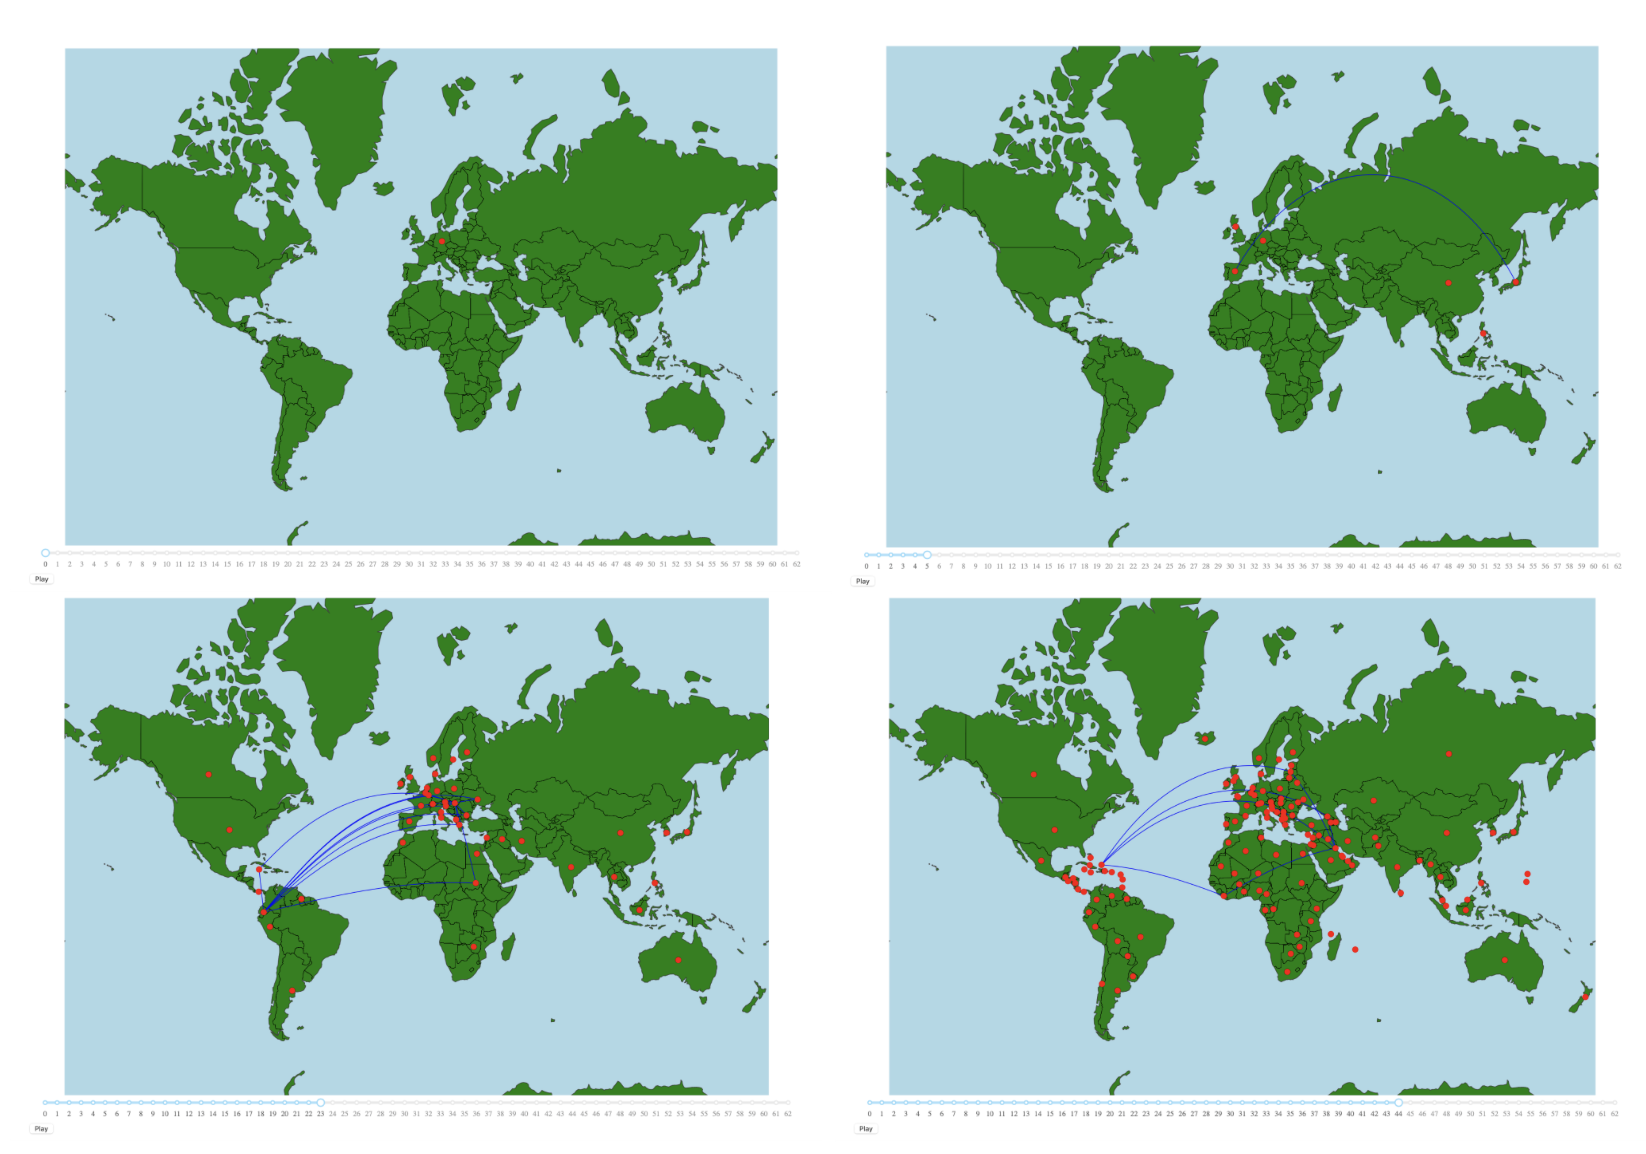

The final code is below. We decided for the best experience to view the spread of the virus as a heatmap rather than red dots.

In [ ]:
"""
* GUI File
* Last Updated 11/27/23 by Armaan Daryanani
"""

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
from datetime import timedelta, datetime

from dash.exceptions import PreventUpdate

from NeuralProcessingTesting import NeuralProcessingTesting

import json
import geopandas as gpd

from CaseProcessing import CaseProcessing

import pycountry

#reads filename data and stores as dict
def read_data_from_file(filename):
    country_data = {}
    with open(filename, 'r') as file:
        for line in file:
            split_line = line.strip().split("\t")
            country_code, lon, lat, country_name = split_line
            country_data[country_name] = (lat, lon)
        file.close()
    return country_data

filename = "countries.txt"
country_data = read_data_from_file(filename)


with open('countries.geojson') as f:
    countries_geojson = json.load(f)

gdf = gpd.read_file('countries.geojson')

def initialize_color_country():
    country_dict = {}
    #lookup landmass and add to dictionary (country_ISO3 : country_position (on landmass)
    country_position = 0
    country_names = []
    country_ISO3_dict = {}
    with open("ISO3_Names.txt") as ISO3_file:
        for ISO3 in ISO3_file:
            names = ISO3.strip().split(":")
            country_ISO3_dict[names[1].strip()] = names[0].strip()
            country_names.append(names[1].strip())

    with open("countries_by_landmass.txt") as landmass_line:
        for landmass in landmass_line:
            landmass_list = landmass.strip().split("\t")
            for name in country_names:
                if name == landmass_list[1].strip():
                    country_dict[country_ISO3_dict[name]] = landmass_list[0]
    print(country_dict)
    return country_dict

country_dict = initialize_color_country()

#function to get latlong from full country name
def latlong(country_name):
    return country_data.get(country_name, (0, 0))  #default

def construct_data(deaths_filename):
    length_of_set = 0
    start_date_str = "2020-01-03"
    end_date_str = "2023-05-09"

    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    processor = CaseProcessing(deaths_filename)

    current_date = start_date
    data_dict = {}

    prev_latlong_values = set()  #store the previous date's values here

    while current_date <= end_date:
        year, month, day = current_date.year, current_date.month, current_date.day
        country_deaths = processor.exclude_indexes(processor.get_country_deaths_dict(day, month, year))


        latlong_values = set()  #initialize as an empty set for each day

        for country, deaths in country_deaths.items():
            if deaths > 0:
                #get the lat-long pair
                lat_long_pair = latlong(country)
                if lat_long_pair != (0, 0):
                    lat, long = lat_long_pair
                    latlong_values.add((lat, f'{long}{deaths}{len(str(deaths))}'))

        date_str = current_date.strftime('%Y-%m-%d')

        #find new points that weren't in the previous day's data
        new_points = latlong_values - prev_latlong_values

        #if there are new points update the data dictionary for the day
        if new_points:
            #combine new points with previous points with the new points at the top
            combined_points = list(prev_latlong_values) + list(new_points)
            data_dict[date_str] = combined_points

        prev_latlong_values = latlong_values

        #move to the next date
        current_date += timedelta(days=1)

    print(data_dict)
    return data_dict

#data points dict
data = construct_data("total_deaths.txt")

all_countries = [country.name for country in pycountry.countries]

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='world-map',
        config={'displayModeBar': False},
        style={
            'height': '85vh',
            'width': '89vw',
            'margin': 'auto',
            'marginTop': '30px',
            'marginLeft': '176px'

        }
    ),
    html.Div(id='globe-rotation', style={'display': 'none'}, children="{'lon': 0, 'lat': 0}"),

    #predict button and output on top left
    html.Div([
        html.Button('Predict', id='predict-button-top'),
        html.Div(id='prediction-output', style={'fontSize': '12.6px'})
    ], style={'display': 'flex', 'flexDirection': 'column', 'alignItems': 'flex-start', 'top': '0px', 'left': '10px',
              'position': 'absolute'}),

    #other controls at bottom
    html.Div([
        dcc.Slider(
            id='date-slider',
            min=0,
            max=len(data.keys()) - 1,
            value=0,
            step=None,
            marks=None  #optional: marks for each step
        ),
        html.Button('Play', id='play-button'),
        html.Button('Toggle Projection', id='toggle-projection-button'),

        dcc.Interval(
            id='interval-component',
            interval=3 * 1000,  #in milliseconds where 1*1000 means every second
            n_intervals=0,  #number of times the interval was activated
            max_intervals=-1,  # -1 means no limit
            disabled=True  #starts as disabled
        )
    ], style={'position': 'fixed', 'bottom': '2%', 'left': '2.5%', 'right': '2.5%'})
], style={'backgroundColor': 'white', 'position': 'relative'})

country_names_list = []
country_by_lat = {}
#country is ISO3
with open("ISO3.txt", 'r') as file:
    for line in file:
        country = line.strip()
        country_names_list.append(country)
        full_name = ""
        with open("ISO3_Names.txt", 'r') as names:
            for names_line in names:
                list_of_names = names_line.split(":")
                if list_of_names[0].strip() == country:
                    full_name = list_of_names[1].strip()
        names.close()
        country_by_lat[latlong(full_name)[0]] = country

def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

def get_color(deaths, max_deaths):
    #>200,000
    if deaths > 200000:
        high_max_deaths = 1000000
        #interpolate between dark red and black
        light_red = (255, 0, 0)
        black = (0, 0, 0)
        normalized_high = clamp((deaths - 200000) / high_max_deaths, 0, 1)
        interpolated_rgb_high = tuple(
            int(light_red[i] + (black[i] - light_red[i]) * normalized_high) for i in range(3)
        )
        return f'rgb{interpolated_rgb_high}'
    #<100,000
    if deaths < 100000:
        dark_green = (35, 79, 30)
        light_green = (0, 255, 0)

        normalized_light = clamp(deaths / 100000, 0, 1)
        interpolated_rgb = tuple(
            int(dark_green[i] + (light_green[i] - dark_green[i]) * normalized_light) for i in range(3)
        )
        return f'rgb{interpolated_rgb}'

    else:
        #100,000-200,000
        light_green = (0, 255, 0)
        light_red = (255, 0, 0)
        normalized = clamp((deaths - 100000) / 100000, 0, 1)
        interpolated_rgb = tuple(
            int(light_green[i] + (light_red[i] - light_green[i]) * normalized) for i in range(3)
        )
        return f'rgb{interpolated_rgb}'

@app.callback(
    Output('world-map', 'figure'),
    [Input('date-slider', 'value'), Input('toggle-projection-button', 'n_clicks')],
    [State('world-map', 'figure')]
)
def update_map(date_index, toggle_clicks, current_fig):
    date = list(data.keys())[date_index]
    coords = data[date]
    new_coords_list = []
    traces = []
    deaths_by_country = {}

    if toggle_clicks is None:
        toggle_clicks = 0

    projection_type = "orthographic" if toggle_clicks % 2 != 0 else "mercator"

    #this loop will process the coordinates and separate the deaths
    for coord in coords:
        lat, long_deaths = coord
        len_deaths = int(str(long_deaths)[-1])
        deaths_str = str(long_deaths)[-(len_deaths + 1):-1]
        deaths = int(deaths_str)


        lat, long = coord
        length = len(str(long)) - (int(long[-1]) + 1)
        new_long = long[0:length]
        new_coord = (lat, new_long)
        new_coords_list.append(new_coord)
        print(long_deaths, deaths)

        for lat_country, country in country_by_lat.items():
            if lat_country == lat:
                deaths_by_country[country] = deaths

    "-----------------------------------"
    index = 0
    max_deaths = 200000
    for country in country_names_list:
        index += 1
        if index == 249:
            break
        else:
            print(country)
            mapped_value = 0.3
            rounded_mapped_val = round(mapped_value, 2)
            #print(deaths_by_country)
            deaths = deaths_by_country.get(country, 0)
            color = get_color(int(deaths), max_deaths)

            #create a copy for the specific country's geometry and simplify that
            country_geometry = gdf[gdf['ISO_A3'] == country].copy()
            country_geometry['geometry'] = country_geometry['geometry'].simplify(tolerance=rounded_mapped_val)
            simplified_geojson = json.loads(country_geometry.to_json())

            colored_country = go.Choropleth(
                geojson=simplified_geojson,
                locations=[country],
                z=[int(deaths)],
                colorscale=[[0, color], [1, color]],
                hoverinfo="location+z",
                showscale=False,
                featureidkey="properties.ISO_A3"
            )
            traces.append(colored_country)
    "-----------------------------------"

    center = {'lat': 0, 'lon': 0}


    #layout of the map we are using
    layout = go.Layout(
        geo={
            'projection': {'type': projection_type},
            'center': center,
            'showland': True,
            'landcolor': '#234F1E',
            'showocean': True,
            'oceancolor': '#006994',
            'showcountries': False,
            'countrycolor': 'black',
            'countrywidth': 0.5,
            'showframe': False,
            'showcoastlines': True,
            'lataxis': {'range': [-60, 80]},
            'lonaxis': {'range': [-180, 180]}
        },
        margin={"t": 0, "b": 0, "l": 0, "r": 0},
        showlegend = False
    )

    return {'data': traces, 'layout': layout}
@app.callback(
    Output('date-slider', 'value'),
    [Input('interval-component', 'n_intervals')],
    [State('date-slider', 'value')]
)
def update_slider(n, current_value):
    if current_value < len(data.keys()) - 1:
        return current_value + 1
    else:
        return current_value

@app.callback(
    Output('prediction-output', 'children'),
    [Input('predict-button-top', 'n_clicks')],
    [State('date-slider', 'value')],
    prevent_initial_call=True
)
def update_predictions(n_clicks, slider_value):
    if n_clicks is None:
        raise PreventUpdate

    #use the slider value to represent the days passed since the initial date
    days_passed = slider_value


    neural_processor = NeuralProcessingTesting()
    top_5_predicted = neural_processor.predict_next(days_passed)

    #check if the result is not None and is iterable
    if top_5_predicted and isinstance(top_5_predicted, list):
        #create a list of Dash HTML components for displaying the predictions
        predictions_list = [html.Li(f"{country}: {deaths}") for country, deaths in top_5_predicted]
    else:
        predictions_list = [html.Li("No predictions available")]

    #return the formatted list
    return html.Ol(predictions_list)


@app.callback(
    [Output('interval-component', 'disabled'),
     Output('play-button', 'children')],
    [Input('play-button', 'n_clicks')],
    [State('interval-component', 'disabled')]
)
def toggle_play(n_clicks, currently_disabled):
    if n_clicks is None:  #the button was never clicked
        return True, "Play"

    if currently_disabled:
        return False, "Pause"
    else:
        return True, "Play"


#driver
if __name__ == '__main__':
    app.run_server(debug=False)

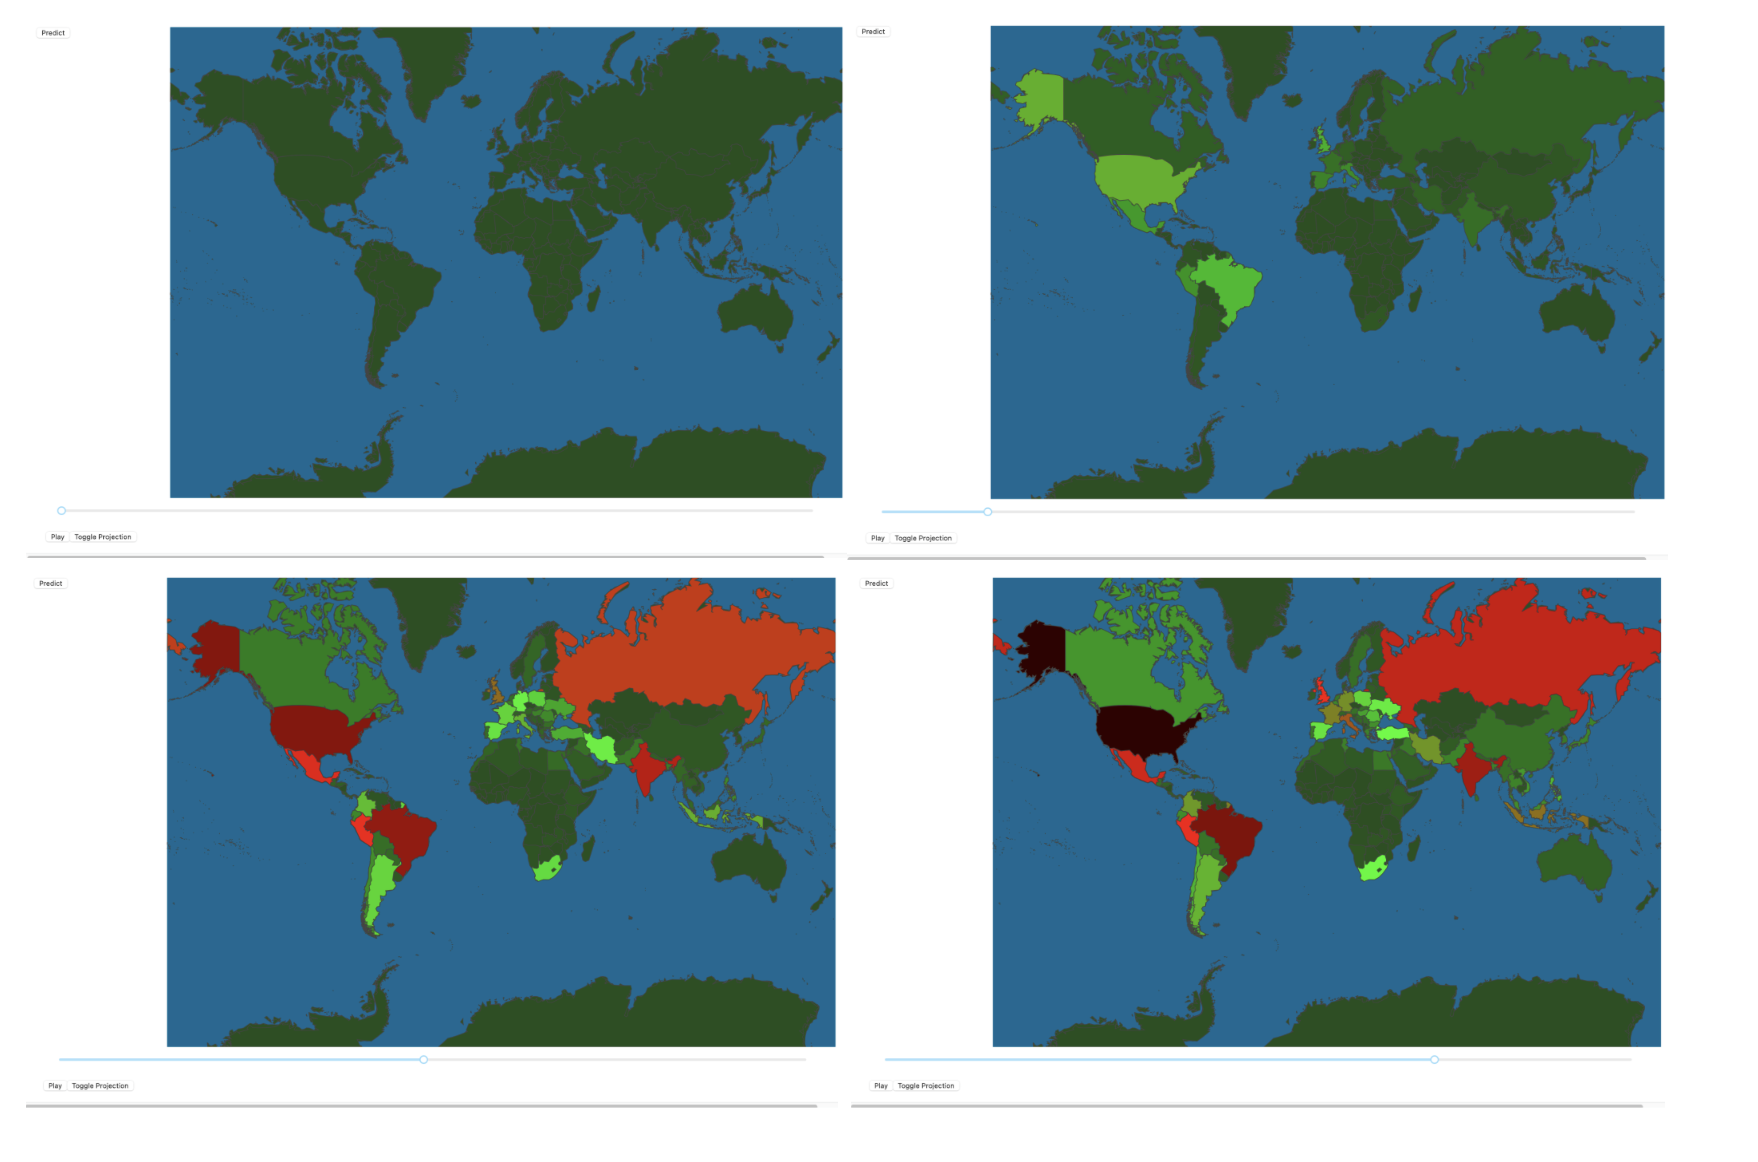

We also added the Toggle Projection button which changes the map from mercator to an interactive orthographic globe map (make sure to check that out!)

##**NeuralProcessing.py: Design and Implementation**
---

> "**TensorFlow** makes it easy for beginners and experts to create machine learning models for desktop, mobile, web, and cloud" [source.](https://www.tensorflow.org/learn)

We used TensorFlow to our program in order to predict the spread of the virus for the next day.

Below is the design for our network and the final implementation in our code.

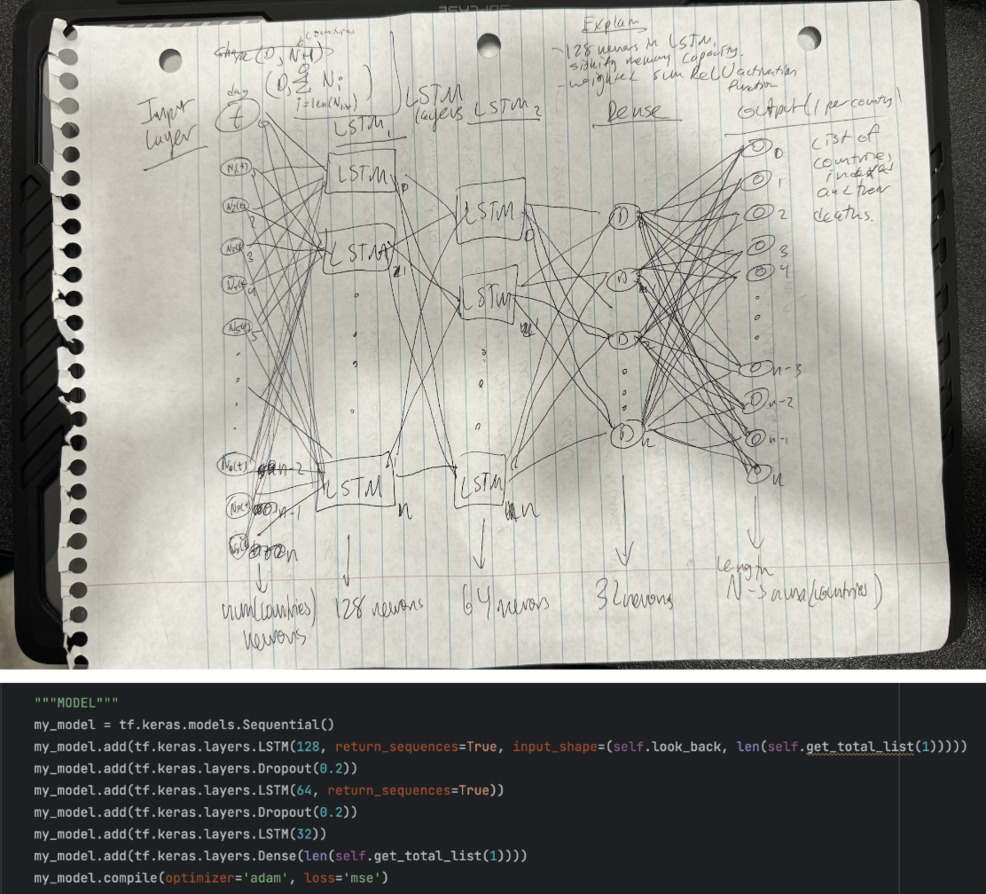

Here we have five layers, the input, LSTM1, LSTM2, LSTM3, and dense layer as our output.   

> An LSTM layer is an RNN layer that learns long-term dependencies between time steps in time-series and sequence data. The layer performs additive interactions, which can help improve gradient flow over long sequences during training. [source.](https://www.mathworks.com/help/deeplearning/ref/nnet.cnn.layer.lstmlayer.html#)

Since we are using three years of daily data, LSTMs are great in capturing these long-period patterns.

 The five layers are defined below.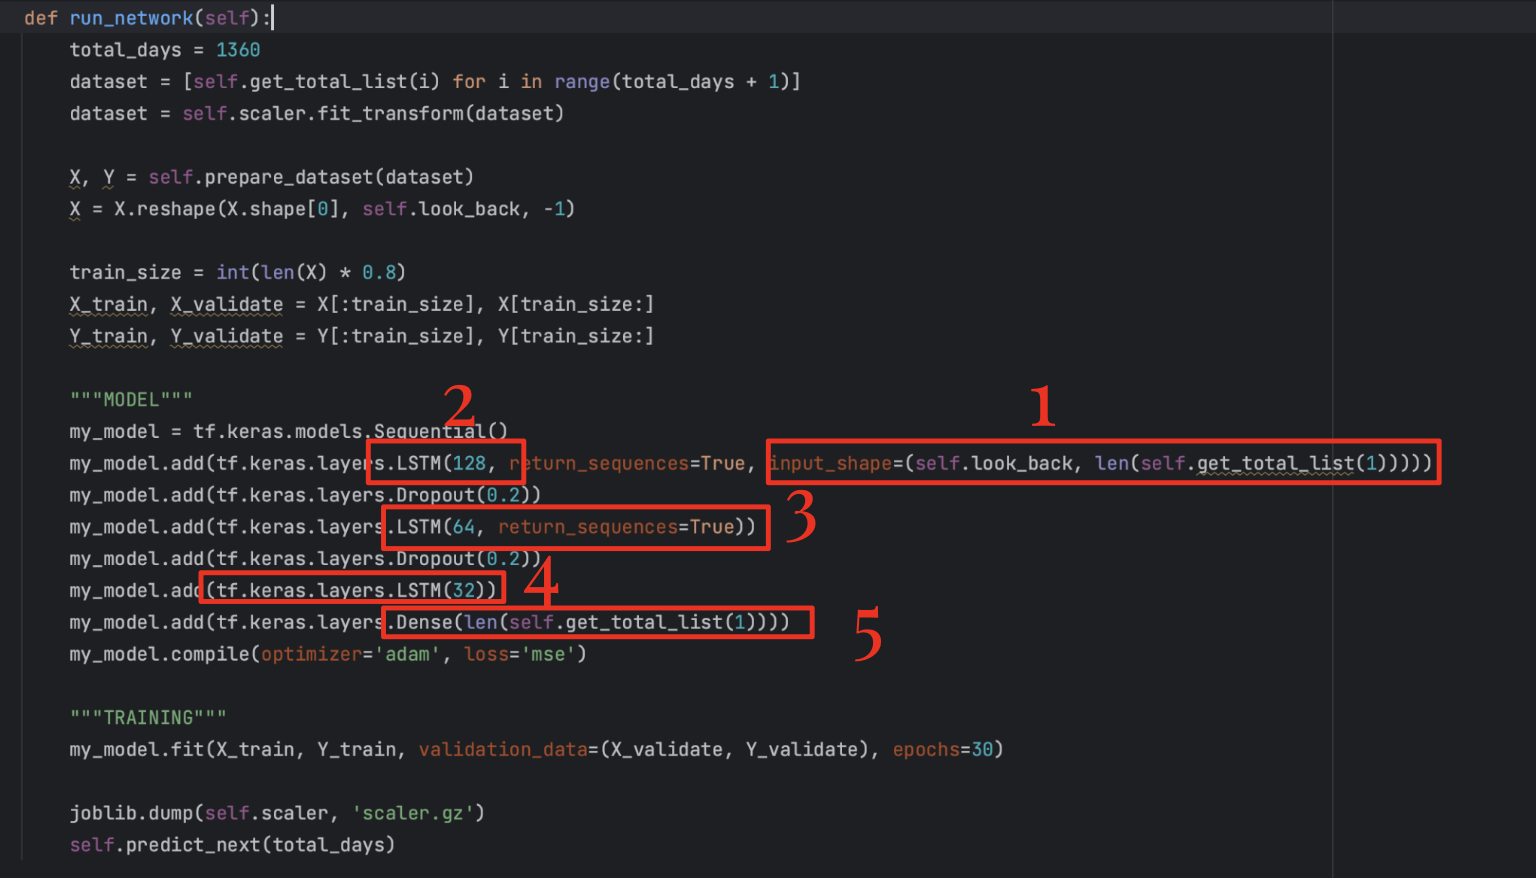

In the complete file, we have functions for preparing the dataset for training, running the network, and predicting the output for the next day.

In order for our program to run smoothly, the code saves our model and reruns the saved version in far less time than retraining.

In [ ]:
import tensorflow as tf
import numpy as np
from datetime import timedelta, datetime

import joblib
from CaseProcessing import CaseProcessing



class NeuralProcessing:
    def __init__(self):
        self.processor = CaseProcessing("total_deaths.txt")
        self.look_back = 1
        self.scaler = None
        self.model = None

    def load_model_and_scaler(self):
        if self.model is None:
            self.model = tf.keras.models.load_model('deaths_model')
        if self.scaler is None:
            self.scaler = joblib.load('scaler.gz')

    def get_total_dict(self, days_passed):
        startdate = "2020-01-03"
        start_date = datetime.strptime(startdate, '%Y-%m-%d')
        final_date = start_date + timedelta(days=days_passed)
        year, month, day = final_date.year, final_date.month, final_date.day

        #get the dictionary of country deaths
        country_deaths = self.processor.get_country_deaths_dict(day, month, year)

        #exclude unnecessary indices
        country_deaths_cleaned = self.processor.exclude_indexes(country_deaths)

        return country_deaths_cleaned

    def get_total_list(self, days_passed):
        startdate = "2020-01-03"
        start_date = datetime.strptime(startdate, '%Y-%m-%d')
        final_date = start_date + timedelta(days=days_passed)
        year, month, day = final_date.year, final_date.month, final_date.day
        death_list = self.processor.exclude_indexes(self.processor.get_country_deaths_dict(day, month, year), True)
        death_list.insert(0, days_passed)
        return death_list

    def prepare_dataset(self, dataset):
        X, Y = [], []
        for i in range(len(dataset) - self.look_back):
            X.append(dataset[i:(i + self.look_back)])
            Y.append(dataset[i + self.look_back])
        return np.array(X), np.array(Y)

    def run_network(self):
        total_days = 1360
        dataset = [self.get_total_list(i) for i in range(total_days + 1)]
        dataset = self.scaler.fit_transform(dataset)

        X, Y = self.prepare_dataset(dataset)
        X = X.reshape(X.shape[0], self.look_back, -1)

        train_size = int(len(X) * 0.8)
        X_train, X_validate = X[:train_size], X[train_size:]
        Y_train, Y_validate = Y[:train_size], Y[train_size:]

        """MODEL"""
        my_model = tf.keras.models.Sequential()
        my_model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(self.look_back, len(self.get_total_list(1)))))
        my_model.add(tf.keras.layers.Dropout(0.2))
        my_model.add(tf.keras.layers.LSTM(64, return_sequences=True))
        my_model.add(tf.keras.layers.Dropout(0.2))
        my_model.add(tf.keras.layers.LSTM(32))
        my_model.add(tf.keras.layers.Dense(len(self.get_total_list(1))))
        my_model.compile(optimizer='adam', loss='mse')

        """TRAINING"""
        my_model.fit(X_train, Y_train, validation_data=(X_validate, Y_validate), epochs=30)

        joblib.dump(self.scaler, 'scaler.gz')
        self.predict_next(total_days)

    def predict_next(self, total_days):
        """PREDICTION"""
        my_model = tf.keras.models.load_model('deaths_model')
        self.scaler = joblib.load('scaler.gz')

        #fetch the list of countries in the correct order from the actual next day data
        actual_next_day_data = self.get_total_dict(total_days + 1)
        countries = list(actual_next_day_data.keys())

        #get the actual current day's data
        current_day_data = self.get_total_dict(total_days)

        #remove 'High income' key from the dictionaries
        current_day_data.pop('High income', None)
        actual_next_day_data.pop('High income', None)

        current_day_data.pop('Democratic Republic of the Congo', None)
        actual_next_day_data.pop('Democratic Republic of the Congo', None)


        last_day_data = np.array([self.get_total_list(total_days)])

        last_day_data = self.scaler.transform(last_day_data)
        last_day_data = last_day_data.reshape(1, self.look_back, -1)
        prediction_next_day = my_model.predict(last_day_data)
        prediction_next_day = self.scaler.inverse_transform(prediction_next_day)

        #extract the first row of predictions and ignore the first value (days_passed)
        next_day_predictions = prediction_next_day[0][1:]  # Skip the first element (days_passed)

        #replace negative values with zero and map to corresponding countries
        predictions_dict = {country: max(0, int(pred)) for country, pred in zip(countries, next_day_predictions)}

        #remove 'High income' key from the prediction dictionary
        predictions_dict.pop('High income', None)
        predictions_dict.pop('Democratic Republic of the Congo', None)


        top_5_predicted_total_deaths = sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True)[:50]

        return top_5_predicted_total_deaths



And here is the neural prediction:

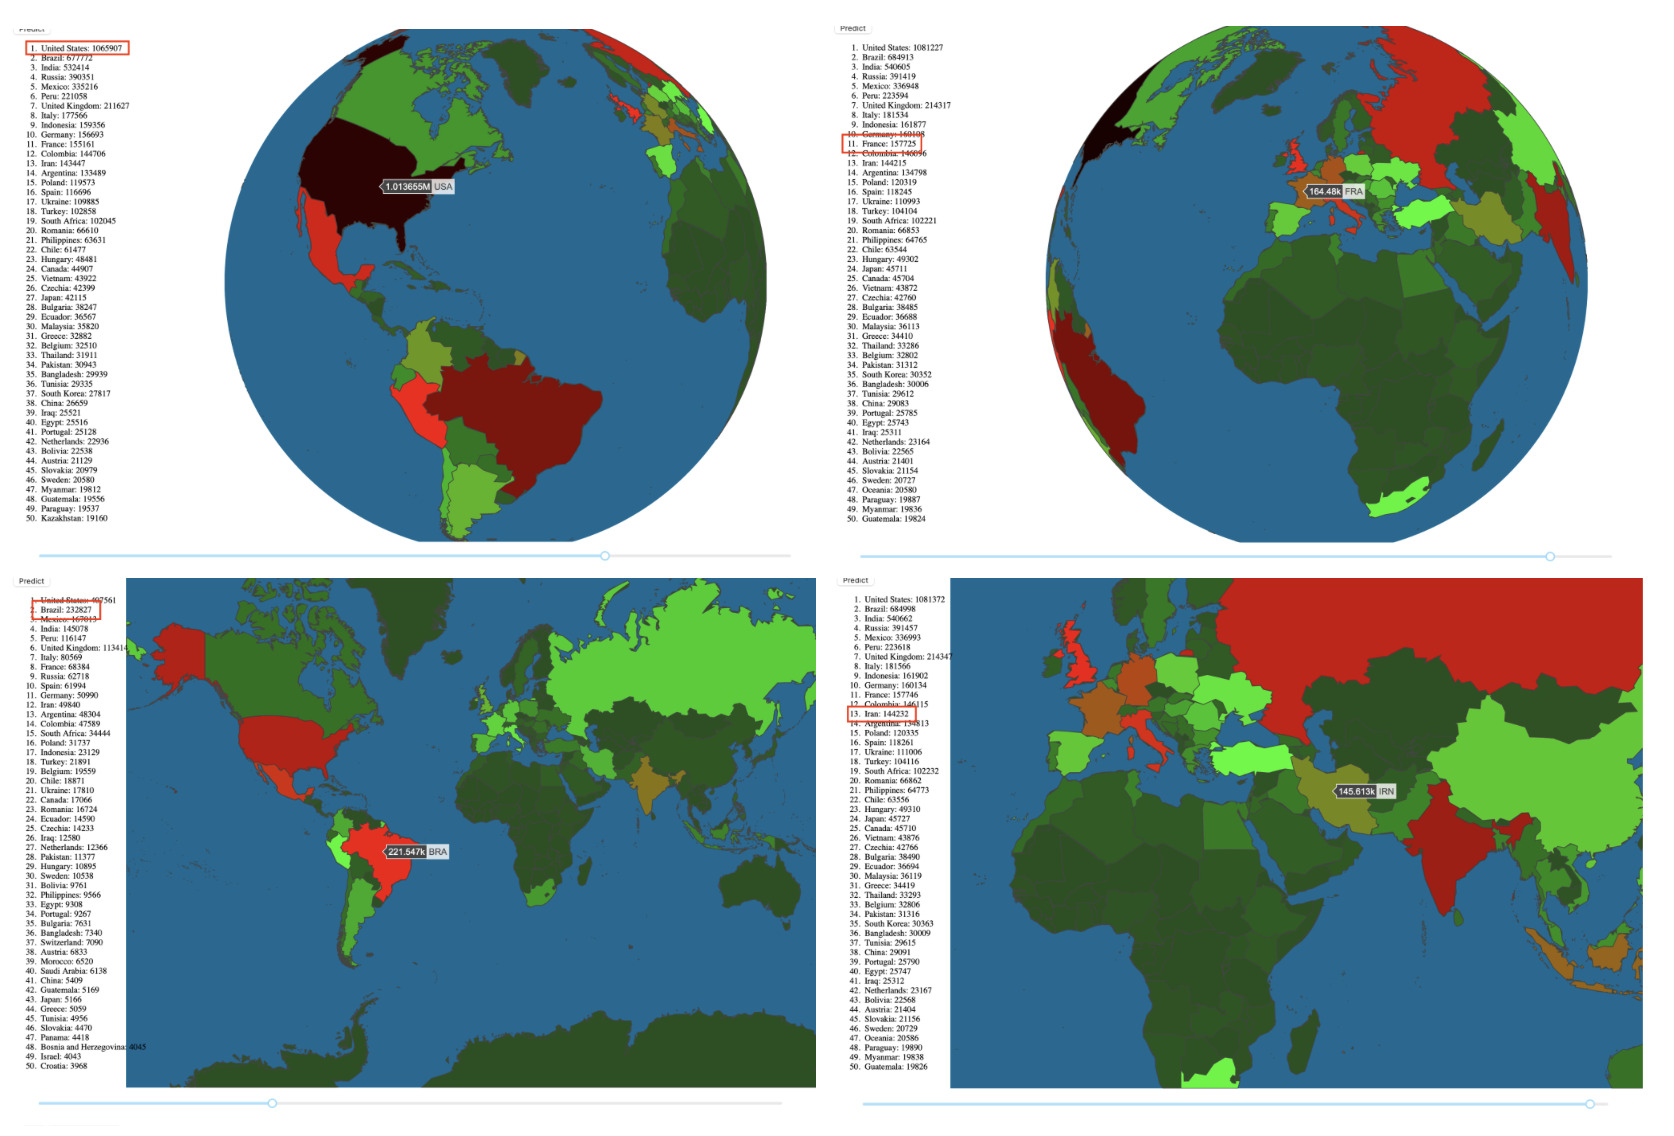

Each tile in the picture above shows the predicted deaths for the next day on the left and the hovered country's deaths in the globe map. The orthographic map (top two tiles) are able to be rotated seamlessly with zoom functionality as well (bottom right).

#**Closing Statements**
---

###**The Work**

My name is Armaan and I was the Scrum Master, the author for this notebook, and the programmer for the majority of the project. All in all working on a project of this magnitude with a team gave me a greater understanding for not only the planning required from start to finish but also the complexity as the project reaches its completion.

Although this project can be improved in many ways, I hope the idea can motivate another team in the future to create an even more complex model with more parameters that could be deployed in the real world!

**Build something you're proud of!**

###**What We Learned**

Out of the 60+ hours spent on the project, apart from troubleshooting, we spent a lot of our time planning and testing different methods for our desired output.

Your program will most likely change as development continues. It's important to plan out your project as development continues and remember to think as **simple as possible** and gradually add complexity as the sprints progress.

**Consistency is the only shortcut.**



###**Our Struggles**

Dash is overall a complex library to work with. We had many issues with the app callbacks and the html elements like the play slider and neural predictions to work properly. For this, trial and error worked in the end.

For the coloring of countries, we needed to simplify the country's border geometries so the program does not lag when interacting with it.

We had to go through 4-5 renditions of the neural network before we landed on the best model. This is when we used LSTM layers as it produced the most accurate output.

**In order to learn you must struggle.**

#***THANK YOU FOR READING!***